In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

In [4]:
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
spark-3.5.1-bin-hadoop3/sbin/slaves.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-shuffle-service.sh
spark-3.5.1-bin-hadoop3/sbin/stop-history-server.sh
spark-3.5.1-bin-hadoop3/sbin/stop-worker.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-thriftserver.sh
spark-3.5.1-bin-hadoop3/sbin/start-worker.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-connect-server.sh


In [5]:
!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [6]:
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [7]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import files

#uploaded = files.upload()
#upload re_u.data

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import numpy as np
import pandas as pd


spark = SparkSession.builder.master("local[*]").getOrCreate()

data = spark.read.csv("re_u.data", header=False)
data = data.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "itemID").withColumnRenamed("_c2", "rating")

# Splitting data into train and test sets
pandas_data = data.toPandas()
train_data, test_data = np.array_split(pandas_data, 2)
train_df = spark.createDataFrame(train_data)
test_df = spark.createDataFrame(test_data)

# Casting data types
def cast_data_types(df):
    df = df.withColumn("userID", df["userID"].cast(IntegerType()))
    df = df.withColumn("itemID", df["itemID"].cast(IntegerType()))
    df = df.withColumn("rating", df["rating"].cast('float'))
    return df

train_df = cast_data_types(train_df)
test_df = cast_data_types(test_df)



In [9]:
results = {}

# parameter combos
rank_values = [5, 7, 10, 20]
max_iter_values = [2, 5, 7, 10, 20]
data_sizes = [2000, 5000, 10000, 20000, 50000, 100000]


for rank in rank_values:
    for max_iter in max_iter_values:
        for data_size in data_sizes:

            train_subset = train_df.limit(data_size)
            test_subset = test_df.limit(data_size)

            als = ALS(maxIter=max_iter, rank=rank, regParam=0.01,
                      userCol="userID", itemCol="itemID", ratingCol="rating",
                      nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")


            model = als.fit(train_subset)

            predictions = model.transform(test_subset)

            evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="mse")
            mse = evaluator.evaluate(predictions)

            results[(rank, max_iter, data_size)] = mse

for params, mse in results.items():
    print(f"Parameters: {params}, MSE: {mse}")


Parameters: (5, 2, 2000), MSE: 11.45118752426713
Parameters: (5, 2, 5000), MSE: 4.307664355268368
Parameters: (5, 2, 10000), MSE: 2.458475003144092
Parameters: (5, 2, 20000), MSE: 1.7956919732435024
Parameters: (5, 2, 50000), MSE: 1.3445872835255104
Parameters: (5, 2, 100000), MSE: 1.3445872835255104
Parameters: (5, 5, 2000), MSE: 7.0040753932319095
Parameters: (5, 5, 5000), MSE: 2.9798063040363485
Parameters: (5, 5, 10000), MSE: 1.9695774452402772
Parameters: (5, 5, 20000), MSE: 1.5788091256993295
Parameters: (5, 5, 50000), MSE: 1.1937951356529557
Parameters: (5, 5, 100000), MSE: 1.1937951356529557
Parameters: (5, 7, 2000), MSE: 5.719633757714976
Parameters: (5, 7, 5000), MSE: 2.609959540135901
Parameters: (5, 7, 10000), MSE: 1.9907763660307372
Parameters: (5, 7, 20000), MSE: 1.5095628989988101
Parameters: (5, 7, 50000), MSE: 1.1888995712617247
Parameters: (5, 7, 100000), MSE: 1.1888995712617247
Parameters: (5, 10, 2000), MSE: 4.796296704238432
Parameters: (5, 10, 5000), MSE: 2.535082

In [10]:
for params, mse in results.items():
    print(f"Parameters (rank, max_iter, data_size): {params}, MSE: {mse}")

Parameters (rank, max_iter, data_size): (5, 2, 2000), MSE: 11.45118752426713
Parameters (rank, max_iter, data_size): (5, 2, 5000), MSE: 4.307664355268368
Parameters (rank, max_iter, data_size): (5, 2, 10000), MSE: 2.458475003144092
Parameters (rank, max_iter, data_size): (5, 2, 20000), MSE: 1.7956919732435024
Parameters (rank, max_iter, data_size): (5, 2, 50000), MSE: 1.3445872835255104
Parameters (rank, max_iter, data_size): (5, 2, 100000), MSE: 1.3445872835255104
Parameters (rank, max_iter, data_size): (5, 5, 2000), MSE: 7.0040753932319095
Parameters (rank, max_iter, data_size): (5, 5, 5000), MSE: 2.9798063040363485
Parameters (rank, max_iter, data_size): (5, 5, 10000), MSE: 1.9695774452402772
Parameters (rank, max_iter, data_size): (5, 5, 20000), MSE: 1.5788091256993295
Parameters (rank, max_iter, data_size): (5, 5, 50000), MSE: 1.1937951356529557
Parameters (rank, max_iter, data_size): (5, 5, 100000), MSE: 1.1937951356529557
Parameters (rank, max_iter, data_size): (5, 7, 2000), MSE

           Parameters        MSE
0        (5, 2, 2000)  11.451188
1        (5, 2, 5000)   4.307664
2       (5, 2, 10000)   2.458475
3       (5, 2, 20000)   1.795692
4       (5, 2, 50000)   1.344587
..                ...        ...
115    (20, 20, 5000)   2.282122
116   (20, 20, 10000)   2.015434
117   (20, 20, 20000)   1.678885
118   (20, 20, 50000)   1.402295
119  (20, 20, 100000)   1.402295

[120 rows x 2 columns]


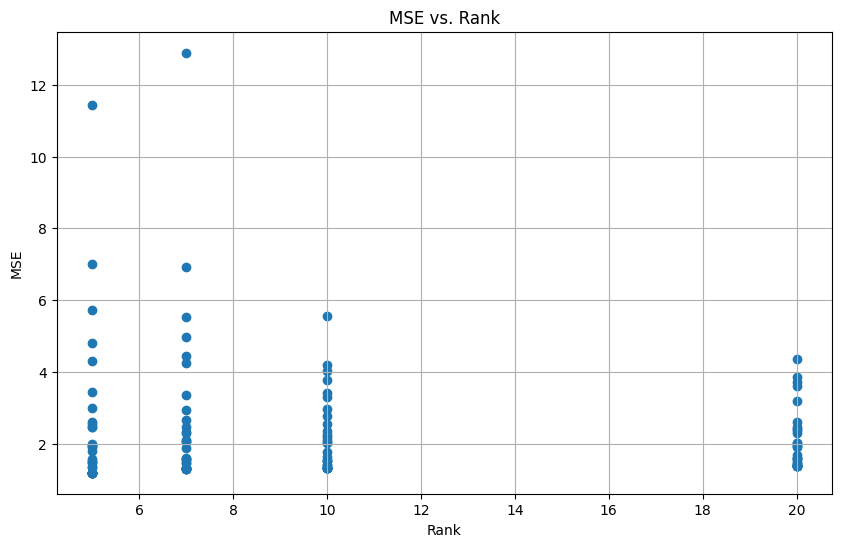

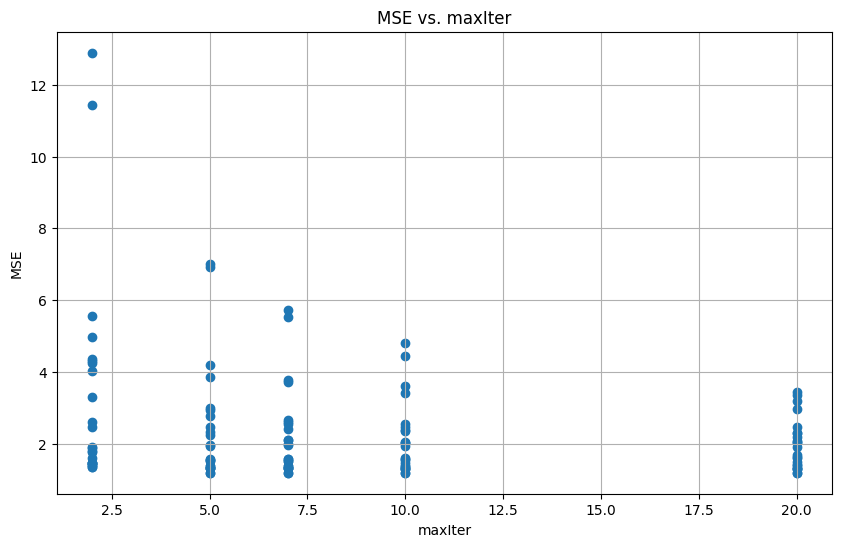

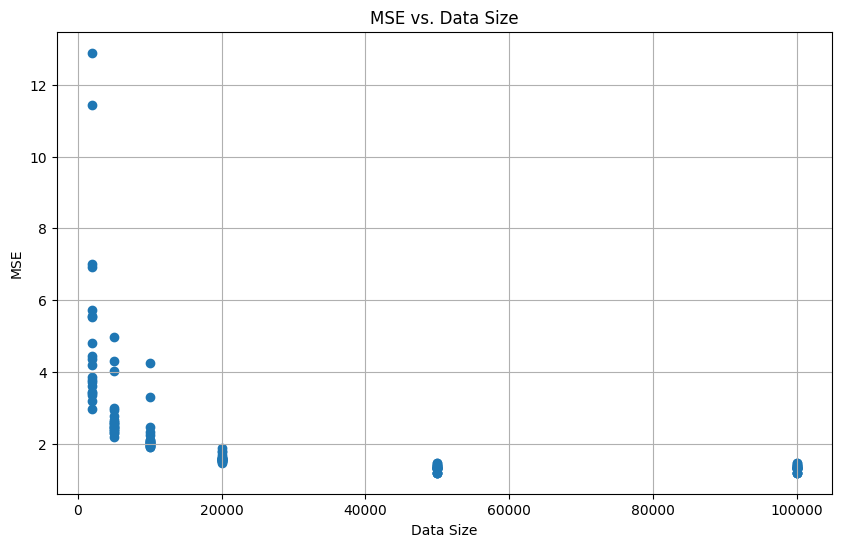

In [12]:
results_df = pd.DataFrame(list(results.items()), columns=['Parameters', 'MSE'])
print(results_df)

import matplotlib.pyplot as plt

rank = [param[0] for param in results_df['Parameters']]
maxIter = [param[1] for param in results_df['Parameters']]
data_size = [param[2] for param in results_df['Parameters']]

# Plotting MSE vs. Rank
plt.figure(figsize=(10, 6))
plt.scatter(rank, results_df['MSE'], marker='o')
plt.xlabel('Rank')
plt.ylabel('MSE')
plt.title('MSE vs. Rank')
plt.grid(True)
plt.show()

# Plotting MSE vs. maxIter
plt.figure(figsize=(10, 6))
plt.scatter(maxIter, results_df['MSE'], marker='o')
plt.xlabel('maxIter')
plt.ylabel('MSE')
plt.title('MSE vs. maxIter')
plt.grid(True)
plt.show()

# Plotting MSE vs. Data Size
plt.figure(figsize=(10, 6))
plt.scatter(data_size, results_df['MSE'], marker='o')
plt.xlabel('Data Size')
plt.ylabel('MSE')
plt.title('MSE vs. Data Size')
plt.grid(True)
plt.show()

